In [1]:
from typing import List, Dict, Mapping, Tuple

import chex
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax
import tensorflow as tf
import pdb
import functools

def println(*args):
  for arg in args:
    print(arg)


In [2]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
DEVICE_COUNT = len(jax.devices())
DEVICE_COUNT

8

In [4]:
BATCH_SIZE = 512

## Dataset pipline

In [5]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def create_dataset():
  # Create a TensorFlow data pipeline for the training set
  train_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_train, y_train))
      .repeat()
      .shuffle(buffer_size=5000)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())

  # Create a TensorFlow data pipeline for the test set.
  test_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_test, y_test))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())
  return train_dataset, test_dataset

def get_batch(dataset):
  images, labels = next(dataset)

  images, labels = jnp.array(images), jnp.array(labels)
  images = jnp.reshape(images, (BATCH_SIZE, -1)) # flatten the images
  return images, labels

train_dataset, test_dataset = create_dataset()

11490434/11490434 [==============================] - 0s 0us/step


### test get_batch

In [6]:
test_images, test_labels = get_batch(train_dataset)
test_images.shape, test_labels.shape

((512, 784), (512, 10))

In [7]:
test_image, test_label = test_images[0], test_labels[0]
test_image.shape

(784,)

## Modeling

In [8]:
class Autoencoder(nn.Module):
  @nn.compact
  def __call__(self, x, training=False):
      x = jnp.reshape(x, (28, 28, 1))

      # encoder
      x = nn.Conv(16, (3, 3), strides=(2, 2), padding="SAME")(x)
      x = nn.relu(x)
      x = nn.Conv(32, (3, 3), strides=(2, 2), padding="SAME")(x)
      x = nn.relu(x)
      x = nn.Conv(64, (3, 3), strides=(2, 2), padding="SAME")(x)
      x = nn.relu(x)
      x = jnp.reshape(x, (-1)) # flatten
      x = nn.Dense(3136)(x) # project to flat dimension of 3136, so that you can reconstruct 7x7x64 image from that by reshape

      # decoder
      x = jnp.reshape(x, (7, 7, 64))
      x = nn.ConvTranspose(32, (3, 3), strides=(2, 2), padding="SAME")(x)
      x = nn.relu(x)
      x = nn.ConvTranspose(1, (3, 3), strides=(2, 2), padding="SAME")(x)
      x = nn.sigmoid(x)
      return x

In [9]:
class TrainState(train_state.TrainState):
  key: jax.random.KeyArray

random_key = jax.random.PRNGKey(99)
random_key, random_subkey = jax.random.split(random_key)

model = Autoencoder()

output, params = model.init_with_output(jrand.PRNGKey(99), test_image, training=False)
params = params["params"]

In [10]:
def model_apply(params, inputs, training):
  return model.apply({"params": params}, inputs, training=training)

model_apply_batch = jax.vmap(model_apply, in_axes=(None, 0, None), out_axes=(0))

def forward_pass(params, state, batch):
  inputs, _ = batch # you are using reconstruction loss, so NO need of targets.
  reconstructed = state.apply_fn(
      params,
      inputs,
      True # training
    )

  PER_HOST_BATCH_SIZE = BATCH_SIZE // jax.device_count()

  reconstructed = jnp.reshape(reconstructed, (PER_HOST_BATCH_SIZE, -1)) # flatten the reconstructed to (32, 784)

  chex.assert_shape(inputs, (PER_HOST_BATCH_SIZE, 784))
  chex.assert_shape(reconstructed, (PER_HOST_BATCH_SIZE, 784))

  loss = (inputs - reconstructed) ** 2
  loss = loss.mean()
  return loss

def train_step(state, inputs, targets):
  batch = inputs, targets
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0))  # differentiate wrt 0th pos argument.
  params = state.params
  loss, grads = grad_fn(state.params, state, batch)

  loss = jax.lax.pmean(loss, axis_name="devices")
  grads = jax.lax.pmean(grads, axis_name="devices")

  state = state.apply_gradients(grads=grads)
  return state, loss

opt = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model_apply_batch, params=params, tx=opt, key=random_key)

In [11]:
# pmap the train_step.
train_step_pmap = jax.pmap(train_step, in_axes=(0, 0, 0), out_axes=(0), axis_name="devices")

In [12]:
# replicate state
states = jax.device_put_replicated(state, jax.local_devices())

In [13]:
# Training loop
num_epochs = 20
steps_per_epoch = len(x_train) // BATCH_SIZE

for epoch in range(num_epochs):
    print("epoch: ", epoch)
    train_dataset, _ = create_dataset()

    for step in range(steps_per_epoch):
        inputs, targets = get_batch(train_dataset)

        # create device dimension for minibatch
        inputs = inputs.reshape((jax.device_count(), -1, inputs.shape[-1]))
        targets = targets.reshape((jax.device_count(), -1, targets.shape[-1]))

        states, loss = train_step_pmap(states, inputs, targets)
        print("loss", loss[0]) if step%100==0 else None

epoch:  0
loss 0.23065239
loss 0.031852983
epoch:  1
loss 0.027646728
loss 0.017574096
epoch:  2
loss 0.016022949
loss 0.01129257
epoch:  3
loss 0.010939293
loss 0.007989945
epoch:  4
loss 0.0070638964
loss 0.0041995887
epoch:  5
loss 0.004132544
loss 0.0034541117
epoch:  6
loss 0.0034965107
loss 0.0030113945
epoch:  7
loss 0.003128373
loss 0.002690326
epoch:  8
loss 0.0027800137
loss 0.0025850062
epoch:  9
loss 0.0026745256
loss 0.0024531756
epoch:  10
loss 0.0025154287
loss 0.002224735
epoch:  11
loss 0.0024688886
loss 0.002173044
epoch:  12
loss 0.0021768422
loss 0.0020756284
epoch:  13
loss 0.0020945997
loss 0.0019659814
epoch:  14
loss 0.0020872797
loss 0.0018871429
epoch:  15
loss 0.0019896918
loss 0.0019966837
epoch:  16
loss 0.0018144278
loss 0.0017768613
epoch:  17
loss 0.0018042212
loss 0.0016100234
epoch:  18
loss 0.0015396228
loss 0.0014751186
epoch:  19
loss 0.0014536475
loss 0.001518271


In [38]:
state = jax.tree_map(lambda x: x[0], states)

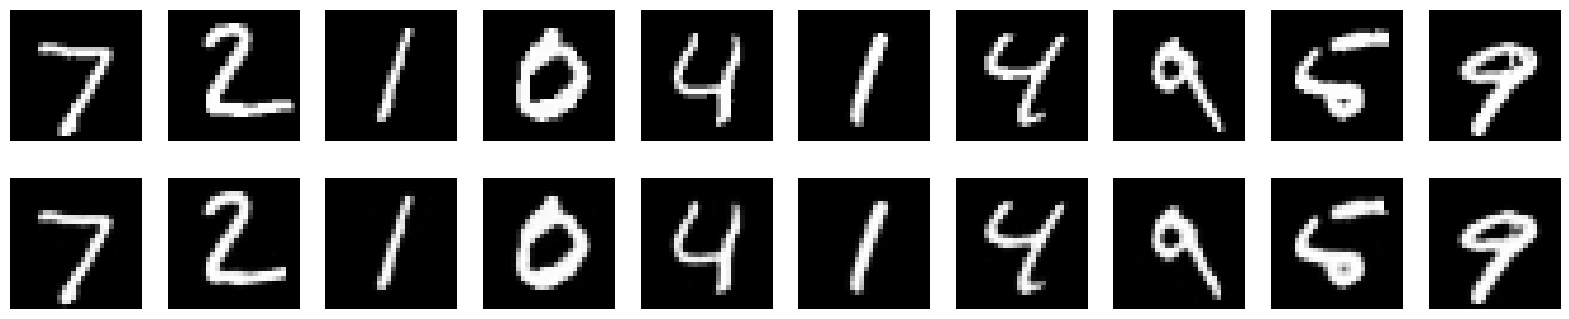

In [41]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, params, batch, n=10):
    inputs, _ = batch
    reconstructed = state.apply_fn(params, inputs, False)
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize some reconstructionsmodel_apply_batch
train_dataset, test_dataset = create_dataset()
plot_reconstructions(model, state.params, get_batch(test_dataset))
